In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
! kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

In [ ]:
mkdir /root/.kaggle/

In [ ]:
mv /content/kaggle.json /root/.kaggle/

In [ ]:
! unzip /content/lgg-mri-segmentation.zip

In [1]:
! pip install torchsummary

In [ ]:
! rm -rf *.txt

In [2]:
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt 
from glob import glob
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as ff
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

# Load Dataset

In [3]:

# data_dir = "/content/kaggle_3m"   
data_dir = "../input/lgg-mri-segmentation/kaggle_3m"


images_dir = []
masks_dir = []
masks_dir = glob(data_dir + '/*/*_mask*')

for i in masks_dir:
    images_dir.append(i.replace('_mask',''))

print("image的长度{}, image前两张{}".format(len(images_dir), images_dir[:2]))
print("mask的长度{}, mask前两张{}".format(len(masks_dir), masks_dir[:2]))

image的长度3929, image前两张['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif']
mask的长度3929, mask前两张['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif']


In [190]:
data = pd.DataFrame({'images':images_dir,'masks':masks_dir})
data.to_csv("a.csv")

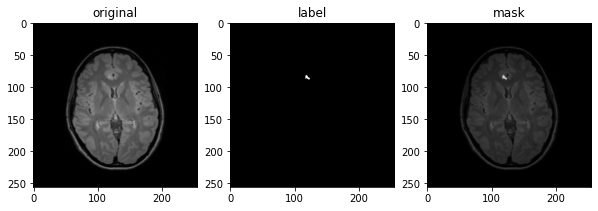

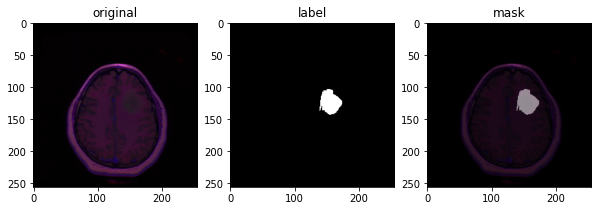

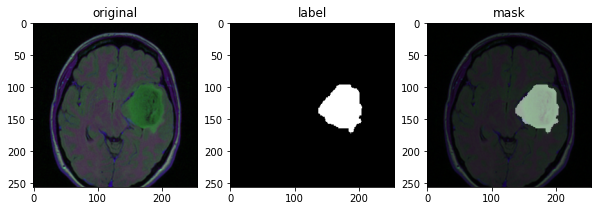

In [5]:

pic_list=[265,895,95]
for N in pic_list:
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    img = cv2.imread(data.images.iloc[N])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,3,2)
    msk=cv2.imread(data.masks.iloc[N])
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    plt.title("label")
    plt.imshow(msk)
    plt.subplot(1,3,3)
    plt.title("mask")
    plt.imshow(img)
    plt.imshow(msk,alpha=0.5)

In [6]:
a = cv2.imread(data.masks.iloc[95])
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

In [7]:
print(a.shape)

(256, 256, 3)


In [8]:

msk=cv2.imread(data.masks.iloc[95])
print(msk.shape)
print(np.unique(msk))

(256, 256, 3)
[  0 255]


In [9]:
class LabelProcessor:

    def __init__(self):
        self.colormap = self.read_color_map()
        self.cm2lbl = self.encode_label_pix(self.colormap)
    
    def encode_label_img(self, img):
        data = np.array(img, dtype='int32')
        idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
        return np.array(self.cm2lbl[idx], dtype='int64')
    
    @staticmethod
    def read_color_map():  
        colormap = []
        colormap.append([0,0,0])
        colormap.append([255,255,255])
        return colormap
    
    @staticmethod
    def encode_label_pix(colormap):     
        cm2lbl = np.zeros(256 ** 3)
        for i, cm in enumerate(colormap):
            cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i
        return cm2lbl

## Build pytorch dataset

In [10]:
class MRIDataset(Dataset):
    
    def __init__(self, img_path, label_path):
       
        if not isinstance(img_path, np.ndarray):
            self.img_path = img_path.to_numpy()
            self.label_path = label_path.to_numpy()
        self.labelProcessor = LabelProcessor()

    def __getitem__(self, index):
        img = self.img_path[index]
        label = self.label_path[index]
        
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = cv2.imread(label)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        # transform
        img, label = self.img_transform(img, label)

        return {'img': img, 'label': label}

    def __len__(self):
        return len(self.img_path)

    def img_transform(self, img, label):
       
        transform_img = transforms.Compose([transforms.ToTensor(),  # 转tensor
                                            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        img = transform_img(img)
        label = self.labelProcessor.encode_label_img(label)
        label = torch.from_numpy(label)

        return img, label

In [11]:
a = MRIDataset(data["images"], data["masks"])
a[0]["img"].shape

torch.Size([3, 256, 256])

# segnet

In [12]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


__all__ = ["SegNet"]

class SegNet(nn.Module):
    def __init__(self, classes=19):
        super(SegNet, self).__init__()

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum=batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum=batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum=batchNorm_momentum)
        self.conv31d = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum=batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum=batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum=batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum=batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, classes, kernel_size=3, padding=1)

    def forward(self, x):
        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1_size = x12.size()
        x1p, id1 = F.max_pool2d(x12, kernel_size=2, stride=2, return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2_size = x22.size()
        x2p, id2 = F.max_pool2d(x22, kernel_size=2, stride=2, return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3_size = x33.size()
        x3p, id3 = F.max_pool2d(x33, kernel_size=2, stride=2, return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4_size = x43.size()
        x4p, id4 = F.max_pool2d(x43, kernel_size=2, stride=2, return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5_size = x53.size()
        x5p, id5 = F.max_pool2d(x53, kernel_size=2, stride=2, return_indices=True)

        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2, output_size=x5_size)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2, output_size=x4_size)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2, output_size=x3_size)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2, output_size=x2_size)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2, output_size=x1_size)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d


"""print layers and params of network"""
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SegNet(classes=19).to(device)
    summary(model, (3, 512, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 512, 1024]           1,792
       BatchNorm2d-2        [-1, 64, 512, 1024]             128
            Conv2d-3        [-1, 64, 512, 1024]          36,928
       BatchNorm2d-4        [-1, 64, 512, 1024]             128
            Conv2d-5        [-1, 128, 256, 512]          73,856
       BatchNorm2d-6        [-1, 128, 256, 512]             256
            Conv2d-7        [-1, 128, 256, 512]         147,584
       BatchNorm2d-8        [-1, 128, 256, 512]             256
            Conv2d-9        [-1, 256, 128, 256]         295,168
      BatchNorm2d-10        [-1, 256, 128, 256]             512
           Conv2d-11        [-1, 256, 128, 256]         590,080
      BatchNorm2d-12        [-1, 256, 128, 256]             512
           Conv2d-13        [-1, 256, 128, 256]         590,080
      BatchNorm2d-14        [-1, 256, 1

# evaluation

In [14]:
a,b= np.array([1,2,3,4]).reshape(2,2)

In [15]:
y,u = a

In [16]:
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])

array([[0, 2],
       [1, 1]])

In [67]:
from __future__ import division
from sklearn.metrics import confusion_matrix
import numpy as np
import six


def calc_semantic_segmentation_confusion(pred_labels, gt_labels):
    pred_labels = pred_labels.flatten()
    gt_labels = gt_labels.flatten()
    confusion = confusion_matrix(gt_labels, pred_labels)
    if len(confusion)!= 2:
        confusion =  np.array([confusion[0][0],0,0,0]).reshape(2,2)
    return confusion


def calc_semantic_segmentation_iou(confusion):
    intersection = np.diag(confusion)
    union = np.sum(confusion, axis=1) + np.sum(confusion, axis=0) - np.diag(confusion)
    Ciou = (intersection / (np.maximum(1.0, union)+  1e-10) )
    mIoU = np.nanmean(Ciou)
    return mIoU

def calc_semantic_segmentation_dice(confusion):
    a, b = confusion
    tn, fp = a
    fn, tp = b
    return np.nanmean(2*tp/(2*tp + fn + fp +  1e-10))

def eval_semantic_segmentation(pred_labels, gt_labels):
    confusion = calc_semantic_segmentation_confusion(pred_labels, gt_labels)
    mIoU = calc_semantic_segmentation_iou(confusion) 
    pixel_accuracy = np.nanmean(np.diag(confusion) / (confusion.sum(axis=1)+  1e-10))
    class_accuracy = np.diag(confusion) / ( confusion.sum(axis=1) +  1e-10 )
    dice = calc_semantic_segmentation_dice(confusion)

    return {'miou': mIoU,
            'pixel_accuracy': pixel_accuracy,
            'class_accuracy': class_accuracy,
            'dice': dice}

In [19]:
rgb = t.randn(1, 3, 64, 64)
net =  SegNet()
out = net(rgb)
print(out.shape)

torch.Size([1, 19, 64, 64])


In [20]:
out = F.log_softmax(out, dim=1)
out = out.max(dim=1)[1].data.cpu().numpy()
true_label = torch.randint(0,2,(1,64,64)).numpy()

In [21]:
eval_semantic_segmentation(out,true_label)

{'miou': 0.49999999999,
 'pixel_accuracy': 0.49999999999,
 'class_accuracy': array([1., 0.]),
 'dice': 0.0}

# train

In [162]:
# 测试训练分割

from sklearn.model_selection import train_test_split

train, test = train_test_split(data,test_size=0.2, shuffle=True, random_state=233)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_class = 2

Load_train = MRIDataset(train["images"], train["masks"])
Load_val= MRIDataset(test["images"], test["masks"])

train_data = DataLoader(Load_train, batch_size=4, shuffle=True, num_workers=1)
val_data = DataLoader(Load_val, batch_size=4, shuffle=True, num_workers=1)

In [31]:
segnet = SegNet()
segnet = segnet.to(device)
criterion = nn.NLLLoss().to(device)
optimizer = optim.Adam(segnet.parameters(), lr=1e-4)

In [32]:
def evaluate(model):
    model = model.eval()
    num_class = 2
    eval_loss = 0
    eval_acc = 0
    eval_miou = 0
    eval_class_acc = 0
    eval_dice = 0
    error = 0

    for j, sample in enumerate(val_data):
        valImg = sample['img'].to(device)
        valLabel = sample['label'].long().to(device)
        
        out = model(valImg)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        eval_loss = loss.item() + eval_loss
        
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = valLabel.data.cpu().numpy()
        eval_metrics = eval_semantic_segmentation(pre_label, true_label)
        eval_acc = eval_metrics['pixel_accuracy'] + eval_acc
        eval_miou = eval_metrics['miou'] + eval_miou

        eval_class_acc =  eval_metrics['class_accuracy'] + eval_class_acc
        eval_dice = eval_metrics['dice'] + eval_dice

    val_str = '|val Acc|: {:.5f}\n|val dice|: {:.5f}\n|val Mean IoU|: {:.5f}\n|val_class_acc|: {:}'.format(
        eval_acc / len(val_data),
        eval_dice / len(val_data),
        eval_miou / len(val_data),
        eval_class_acc / (len(val_data)-error))
    print(val_str)
    
    return eval_acc / len(val_data), eval_dice / len(val_data), eval_miou / len(val_data), eval_class_acc / (len(val_data)-error)

In [33]:
net = segnet.train()

best = [0]
Epoch = 30
train_acc_epoch = []
train_miou_epoch = []
train_dice_epoch = []
train_class_acc_epoch = []

test_acc_epoch = []
test_miou_epoch = []
test_dice_epoch = []
test_class_acc_epoch = []

# 训练轮次
for epoch in range(Epoch):
    
    train_loss = 0
    train_acc = 0
    train_miou = 0
    train_dice = 0
    train_class_acc = 0
    error = 0
    print('Epoch is [{}/{}]'.format(epoch + 1, Epoch))

    # 训练批次
    for i, sample in enumerate(train_data):
        # 载入数据
        img_data = sample['img'].to(device)
        img_label = sample['label'].to(device)
        # 训练
        out = net(img_data)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, img_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = img_label.data.cpu().numpy()
        eval_metrix = eval_semantic_segmentation(pre_label, true_label)
        train_acc += eval_metrix['pixel_accuracy']
        train_miou += eval_metrix['miou']
        if len(eval_metrix['class_accuracy']) < num_class:
            eval_metrix['class_accuracy'] = 0
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
            error += 1
        else:
            train_class_acc = train_class_acc + eval_metrix['class_accuracy']
        train_dice += eval_metrix['dice']
        # 打印每50次
        if i%500 ==0:
            print('|batch[{}/{}]|batch_loss:{:.9f}|'.format(i + 1, len(train_data), loss.item()))

    metric_description = '|Train Acc|: {:.5f}\n|Train dice|: {:.5f}\n|Train Mean IoU|: {:.5f}\n|Train_class_acc|: {:}'.format(
        train_acc / len(train_data),
        train_dice / len(train_data),
        train_miou / len(train_data),
        train_class_acc / (len(train_data)-error))


    print(metric_description)
    print("-----------------")
    test_acc, test_dice, test_miou, test_class_acc = evaluate(net)
    print("-----------------")
    
    test_acc_epoch.append(test_acc)
    test_miou_epoch.append(test_miou)
    test_dice_epoch.append(test_dice)
    test_class_acc_epoch.append(test_class_acc)

    train_acc_epoch.append(train_acc / len(train_data))
    train_miou_epoch.append(train_miou / len(train_data))
    train_dice_epoch.append(train_dice / len(train_data))
    train_class_acc_epoch.append(list(train_class_acc / (len(train_data)-error)))

    # 储存模型
    if max(best) <= train_miou / len(train_data):
        best.append(train_miou / len(train_data))
        torch.save(net.state_dict(), './{}.pth'.format(epoch))
        


Epoch is [1/30]
|batch[1/786]|batch_loss:2.913402319|
|batch[501/786]|batch_loss:0.039215080|
|Train Acc|: 0.61650
|Train dice|: 0.25788
|Train Mean IoU|: 0.59475
|Train_class_acc|: [0.99906371 0.23393704]
-----------------
|val Acc|: 0.75537
|val dice|: 0.47985
|val Mean IoU|: 0.68485
|val_class_acc|: [0.99521955 0.5155113 ]
-----------------
Epoch is [2/30]
|batch[1/786]|batch_loss:0.017978752|
|batch[501/786]|batch_loss:0.024043817|
|Train Acc|: 0.53969
|Train dice|: 0.09254
|Train Mean IoU|: 0.52824
|Train_class_acc|: [0.99927534 0.08009794]
-----------------
|val Acc|: 0.50144
|val dice|: 0.00566
|val Mean IoU|: 0.49603
|val_class_acc|: [0.99999261 0.00288046]
-----------------
Epoch is [3/30]
|batch[1/786]|batch_loss:0.010503819|
|batch[501/786]|batch_loss:0.027865715|
|Train Acc|: 0.61136
|Train dice|: 0.26607
|Train Mean IoU|: 0.59138
|Train_class_acc|: [0.99856936 0.22415249]
-----------------
|val Acc|: 0.50443
|val dice|: 0.01676
|val Mean IoU|: 0.49890
|val_class_acc|: [0.9

In [34]:
len(train_class_acc_epoch)

30

In [ ]:
test_dice_epoch

# validation

In [163]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

BATCH_SIZE = 4


In [164]:
val_data

In [165]:
net = SegNet()
net.to(device)
net.load_state_dict(torch.load('19.pth'))

<All keys matched successfully>

In [166]:
train_acc = 0
train_miou = 0
train_class_acc = 0
train_mpa = 0
error = 0

In [167]:
def evaluate(model):
    net = model.eval()
    num_class = 2
    eval_loss = 0
    eval_acc = 0
    eval_miou = 0
    eval_class_acc = 0
    eval_dice = 0
    error = 0

    for j, sample in enumerate(val_data):
        valImg = sample['img'].to(device)
        valLabel = sample['label'].long().to(device)
        
        out = net(valImg)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, valLabel)
        eval_loss = loss.item() + eval_loss
        
        # 评估
        pre_label = out.max(dim=1)[1].data.cpu().numpy()
        true_label = valLabel.data.cpu().numpy()
        eval_metrics = eval_semantic_segmentation(pre_label, true_label)
        eval_acc = eval_metrics['pixel_accuracy'] + eval_acc
        eval_miou = eval_metrics['miou'] + eval_miou

        eval_class_acc =  eval_metrics['class_accuracy'] + eval_class_acc
        eval_dice = eval_metrics['dice'] + eval_dice

    val_str = '|val Acc|: {:.5f}\n|val dice|: {:.5f}\n|val Mean IoU|: {:.5f}\n|val_class_acc|: {:}'.format(
        eval_acc / len(val_data),
        eval_dice / len(val_data),
        eval_miou / len(val_data),
        eval_class_acc / (len(val_data)-error))
    print(val_str)

In [176]:
evaluate(net)

|val Acc|: 0.82104
|val dice|: 0.63411
|val Mean IoU|: 0.78029
|val_class_acc|: [0.99855678 0.64352821]


# predict

In [177]:
colormap = []
colormap.append([0,0,0])
colormap.append([255,255,255])
cm = np.array(colormap).astype('uint8')

In [178]:
test_img = test["images"].to_numpy()[22:32]
test_label = test["masks"].to_numpy()[22:32]
pd_aa = pd.DataFrame({'images':test_img,'masks':test_label})
Load_val= MRIDataset(pd_aa['images'], pd_aa['masks'])
val_data = DataLoader(Load_val, batch_size=10, shuffle=False, num_workers=1)

In [179]:
smaples = iter(val_data)
sample = smaples.next()

In [180]:
np.unique(sample["label"])

array([0, 1])

In [181]:
sample["img"].shape

torch.Size([10, 3, 256, 256])

In [182]:
valImg = sample['img'].to(device)
valLabel = sample['label'].long().to(device)
out = net(valImg)
out = F.log_softmax(out, dim=1)
pre_label = out.max(1)[1].squeeze().cpu().data.numpy()
pre = cm[pre_label]

In [183]:
true_pic = cm[sample["label"]]
true_pic.shape

(10, 256, 256, 3)

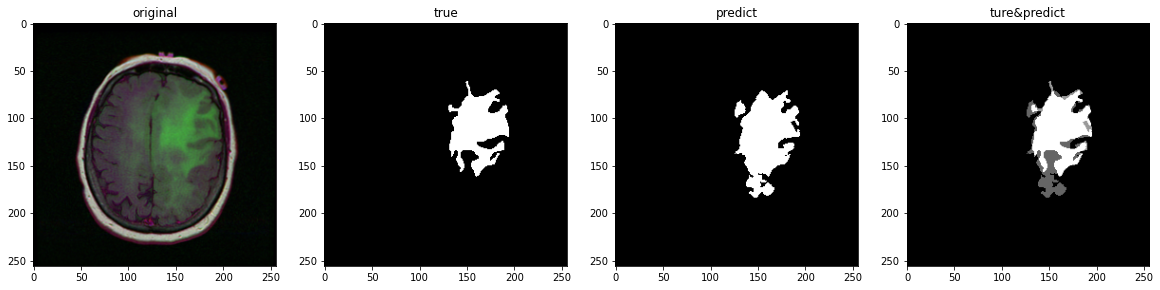

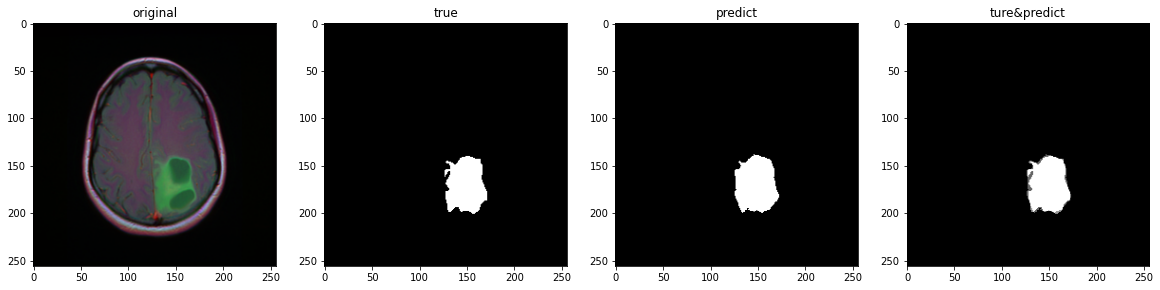

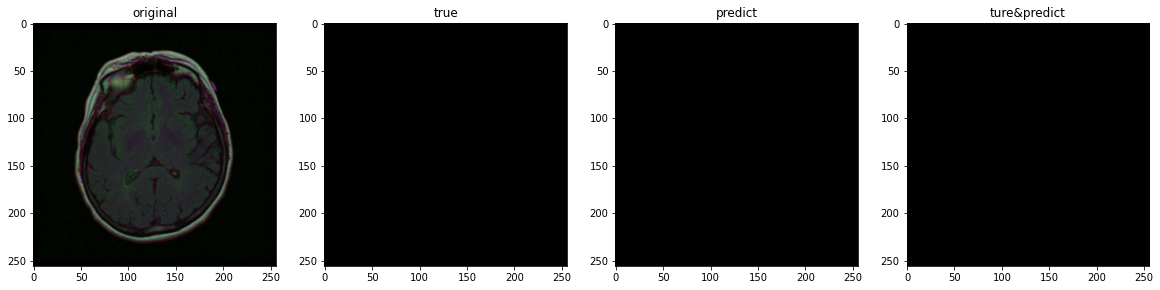

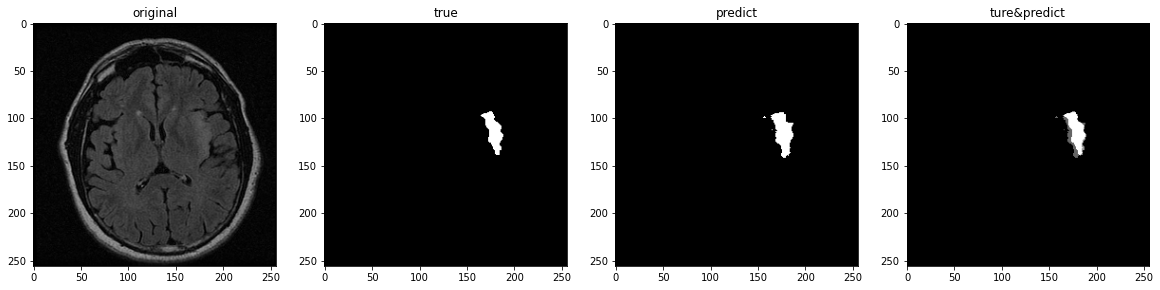

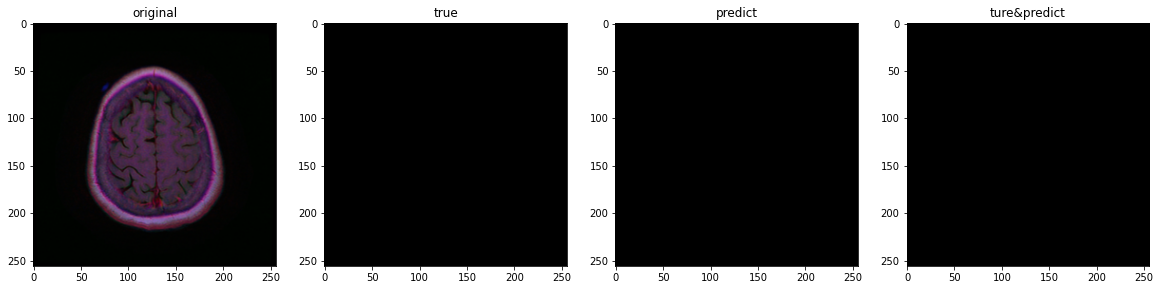

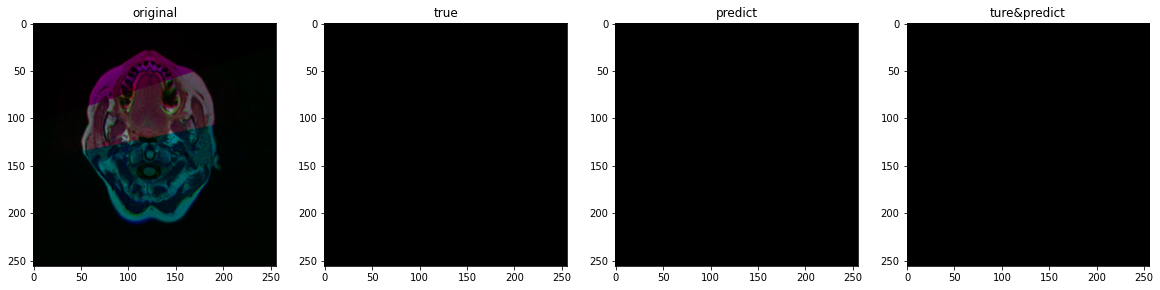

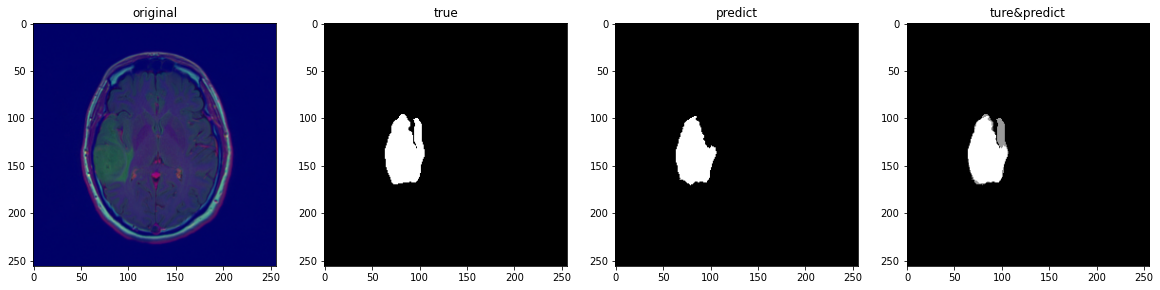

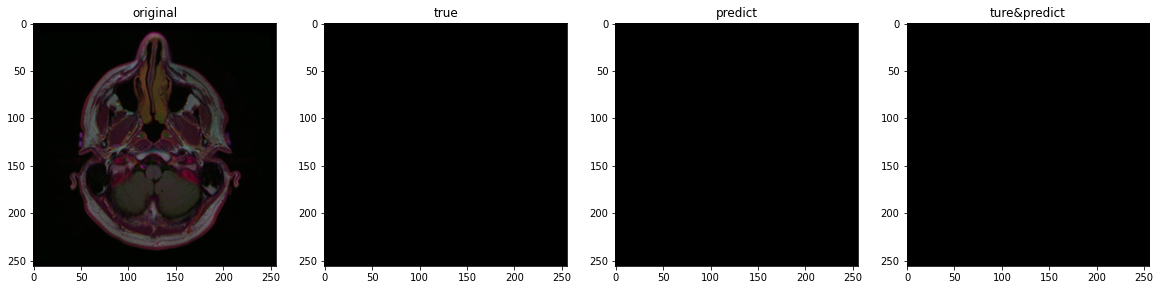

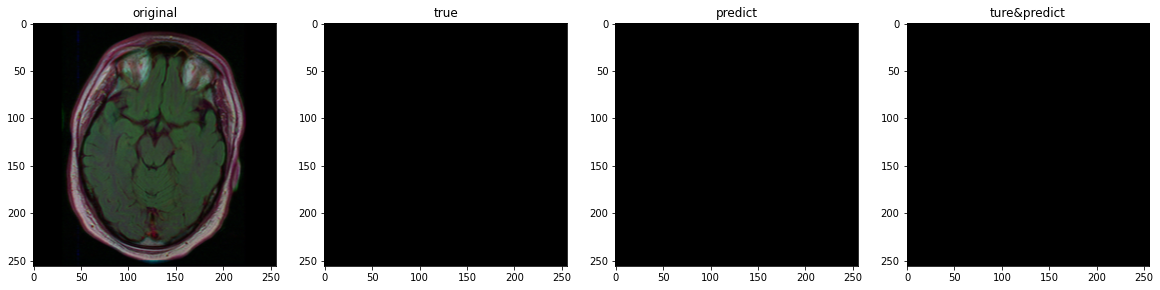

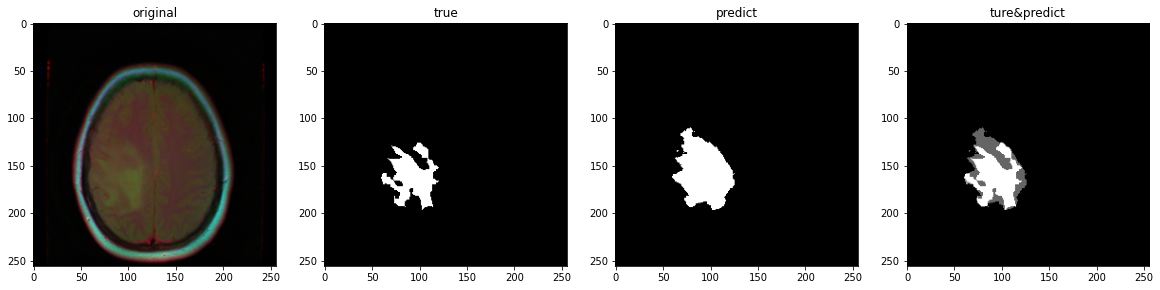

In [184]:
for N in range(10):
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    img=cv2.imread(test_img[N])
    plt.title("original")
    plt.imshow(img)
    plt.subplot(1,4,2)
    plt.title("true")
    plt.imshow(true_pic[N])
    plt.subplot(1,4,3)
    plt.title("predict")
    plt.imshow(pre[N])
    plt.subplot(1,4,4)
    plt.title("ture&predict")
    plt.imshow(true_pic[N])
    plt.imshow(pre[N],alpha=0.4,cmap="jet")

In [185]:
epoch = np.arange(1,31).reshape(30,1)

In [186]:
test_miou_epoch

[0.6848474428437432,
 0.4960285482199723,
 0.49890387342203873,
 0.6461367562017499,
 0.6611309871459887,
 0.6812643779166889,
 0.6666010361349696,
 0.6903791291931489,
 0.7096287643783674,
 0.7377617542845467,
 0.7219356417903239,
 0.7568682884456805,
 0.7695805580393045,
 0.7649838169043999,
 0.7813533038746702,
 0.7907118969434288,
 0.7784421888472631,
 0.7878102916084145,
 0.8051827395339215,
 0.8065480713422102,
 0.7911863792166346,
 0.804593851476084,
 0.8162207112054999,
 0.7904438820889954,
 0.7674034673063799,
 0.8007242861102826,
 0.787258475545098,
 0.7742940942430868,
 0.800238635614074,
 0.7908660325477839]

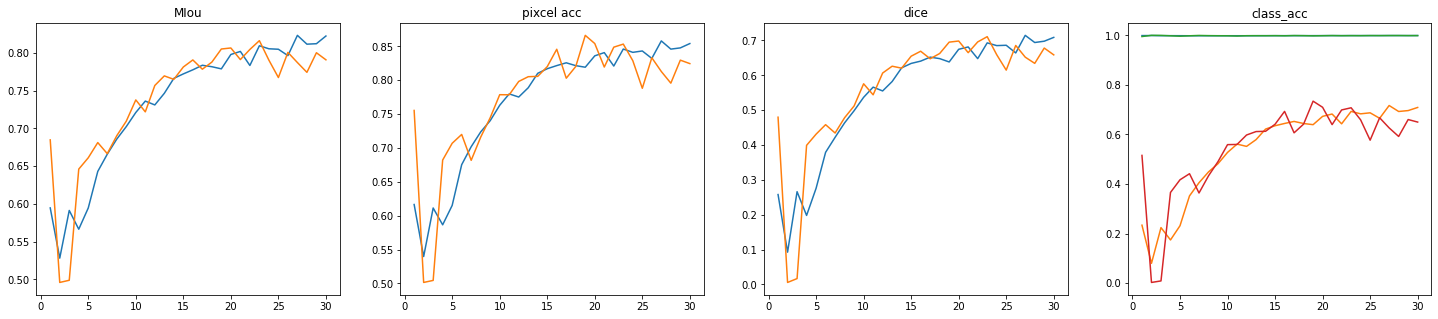

In [187]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.plot(epoch,train_miou_epoch)
plt.plot(epoch,test_miou_epoch)
plt.title("MIou")
plt.subplot(1,4,2)
plt.plot(epoch,train_acc_epoch)
plt.plot(epoch,test_acc_epoch)
plt.title("pixcel acc")
plt.subplot(1,4,3)
plt.plot(epoch,train_dice_epoch)
plt.plot(epoch,test_dice_epoch)
plt.title("dice")
plt.subplot(1,4,4)
plt.plot(epoch,train_class_acc_epoch)
plt.plot(epoch,test_class_acc_epoch)
plt.title("class_acc")
plt.show()

In [188]:
np.savetxt("train_miou_epoch.txt", train_miou_epoch)
np.savetxt("train_acc_epoch.txt", train_acc_epoch)
np.savetxt("train_dice_epoch.txt", train_dice_epoch)
np.savetxt("train_class_acc_epoch.txt", train_class_acc_epoch)

In [189]:
np.savetxt("test_miou_epoch.txt", test_miou_epoch)
np.savetxt("test_acc_epoch.txt", test_acc_epoch)
np.savetxt("test_dice_epoch.txt", test_dice_epoch)
np.savetxt("test_class_acc_epoch.txt", test_class_acc_epoch)